# Image Registration using Homography and Feature Matching

We are going to use the example below shown to where we are interested in digitally extracting the hadwritten information on the image of this scanned form by first aligning it with the template in the middle to produce the align form to the right image.

This would be a pre-processing step that would make optical character recognition of the form much easier.

The multi-step process includes the following steps:

+ Keypoint detection and feature extraction (in both images)
+ Keypoint matching (between the two images)
+ Computing the homography that relates the two images

Transforming the scan form to the align form is not a simple rotation as it might appear, and that's because the photo of the scan form could have benn taken from any number of different perspectives. The process we are going to do is a general transformation that uses homography to transform the scan form into the aligned form. Homography can simply represent a perspective change of the original image.

# Using the homography to warp the perspective of the original image

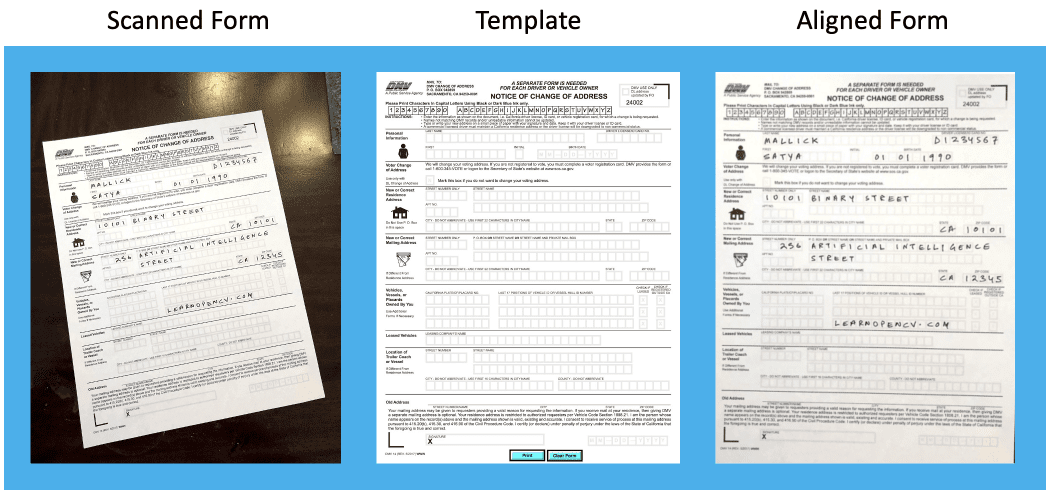

## 1. Geometric Transformations: Review of Theory

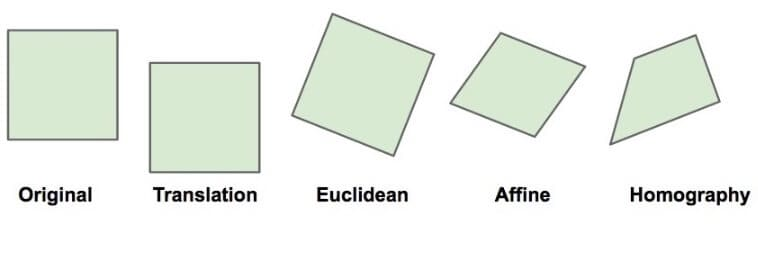

### 1.1 Homography

+ A __Homography__ transforms a square/rectangle to an arbitrary quadrilateral.
+ Images of two planes are related by a __Homography__.
+ We need a minimum of __4 corresponding points__ to estimate a Homography.

This are two images of the same book taken from different perspectives and here wea re interested in talking about homography between these two images, specifically the 2D plane in each image is represented by the front cover of the book. We can identify at least four points in both images that correspond to the same physical location on the front cover of the book, the we can compute the homography that relates these two images.

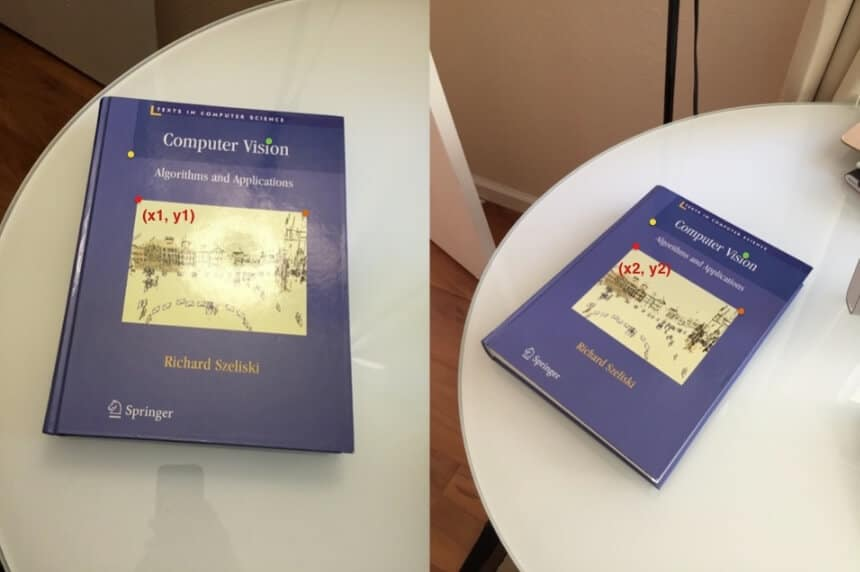

## 2. Implementation

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 2.1 Readn and Display Images of Scanned Form and Template

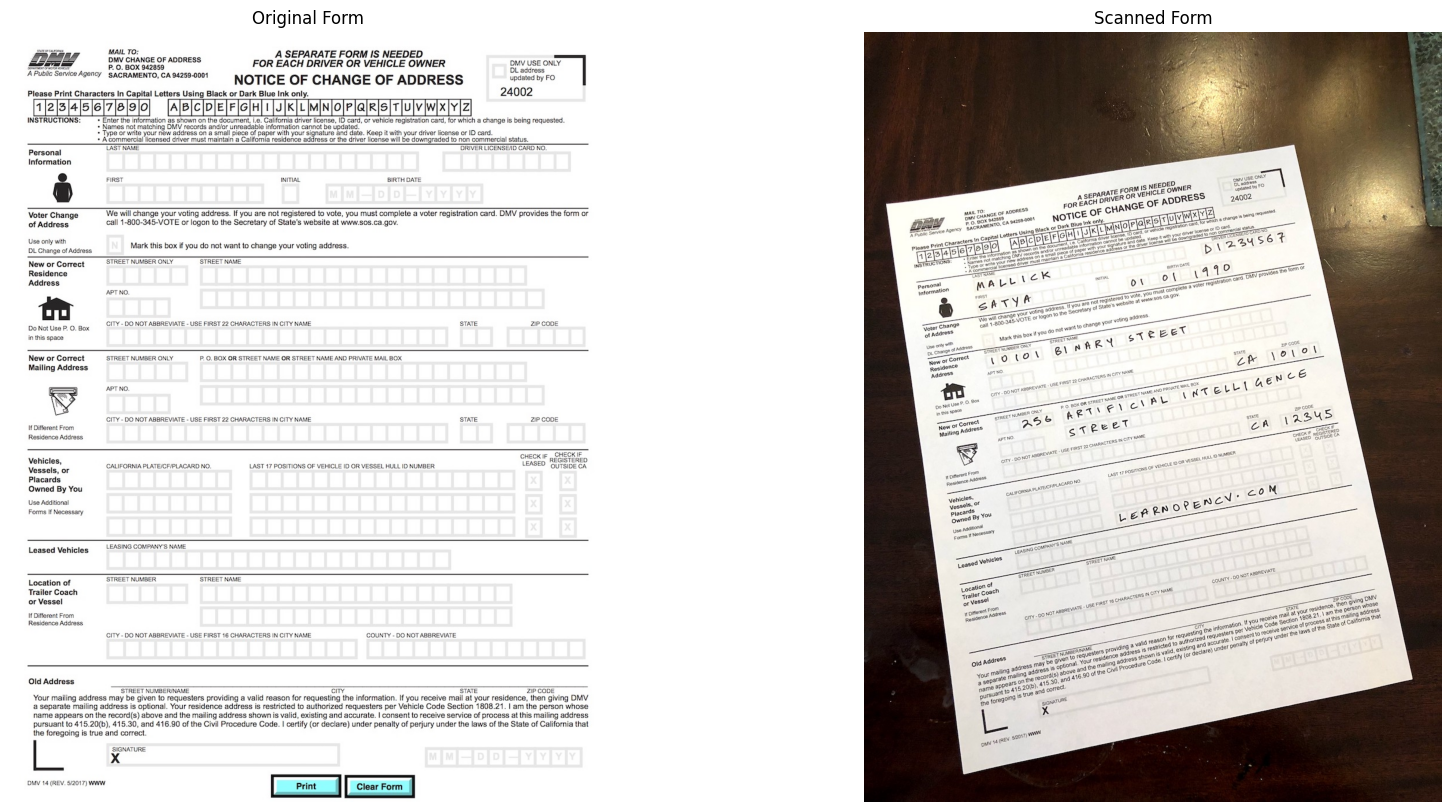

In [2]:
#  Read reference image of the form.
img_form = "./module11/form.jpg"
img_form = cv2.imread(img_form, cv2.IMREAD_COLOR)

# Read the image of the scanned form to be aligned.
img_scan = "./module11/scanned-form.jpg"
img_scan = cv2.imread(img_scan, cv2.IMREAD_COLOR)

# Display the images.
plt.figure(figsize=(20, 10))
plt.subplot(121); plt.axis("off"); plt.imshow(img_form[:, :, ::-1]); plt.title("Original Form")
plt.subplot(122); plt.axis("off"); plt.imshow(img_scan[:, :, ::-1]); plt.title("Scanned Form");

We want to find corresponding points in both images, but we do not want do to it manually but rather automate the process. So conceptually the approach that's taken is to identify well-defined points in both images that typically correspond the corners and then try to match those points in both images, so that we can declare them as a set of corresponding  points and therefore use them for computing the homography.

### 2.2 Find Keypoints in Both Images

The ORB class in OpenCV implements the ORB (Oriented FAST and Rotated BRIEF) keypoint detector and descriptor extractor. Think of keypoints as points within each image that are associated with well-defined corners that are stable under image transformations. Each keypoint has an associated feature descriptor vector. Keypoints and Descriptors can be computed using `detectAndCompute()`. The keypoints themselves can be drawn on the image using a function called `drawKeypoints()`.

---

ORB Class

---

retval = cv2.ORB_create([, nfeatures[, scaleFactor[, nlevels[, edgeThreshold[, firstLevel[, WTA_K[, scoreType[, patchSize[, fastThreshold]]]]]]]]])

### Keypoints and Descriptor Extraction

---

keypoints, descriptors = cv.Feature2D.detectAndCompute(image, mask[, descriptors[, useProvidedKeypoints]])

The function has __2 required arguments__:

1. `image`: Input image.
2. `mask`: input mask (but this can ve specified as `None`)

### Drawing Keypoints

---

outImage = cv2.drawKeypoints(image, keypoints, outImage[, color[, flags]])

The function has __3 required arguments__:

1. `image`: Source image.
2. `keypoints`: Keypoints from the source image.
3. `outImage`: Can be specified as `None` if using return value from function.

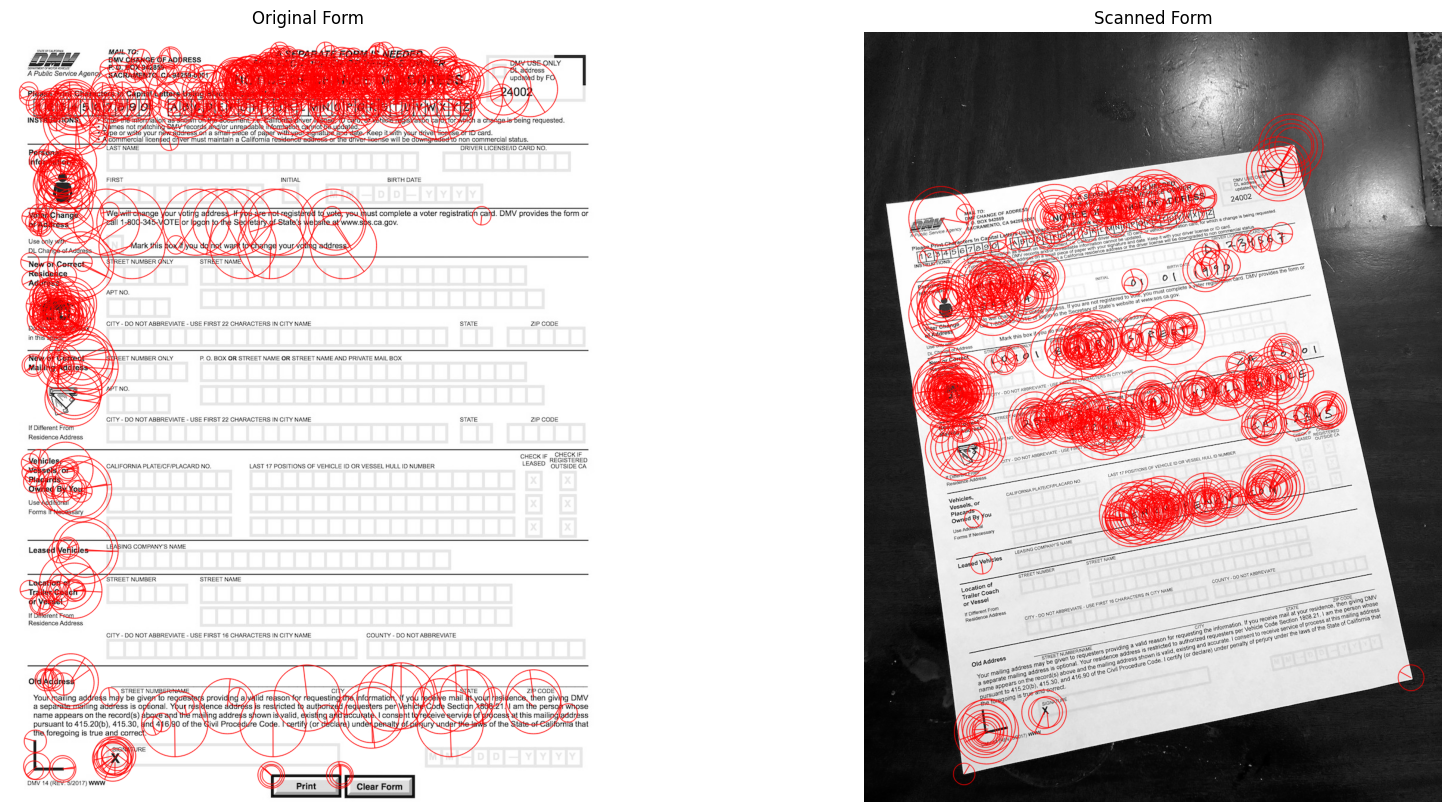

In [3]:
# Convert images to grayscale.
img_form_gray = cv2.cvtColor(img_form, cv2.COLOR_BGR2GRAY)
img_scan_gray = cv2.cvtColor(img_scan, cv2.COLOR_BGR2GRAY)

# Detect keypoints and compute descriptors.
orb = cv2.ORB_create(nfeatures=600)
keypoints1, descriptors1 = orb.detectAndCompute(img_form_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img_scan_gray, None)

# Draw the keypoints in both images.
img_form_keypoints = cv2.drawKeypoints(img_form_gray, keypoints1, None, color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_scan_keypoints = cv2.drawKeypoints(img_scan_gray, keypoints2, None, color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the images with the keypoints.
plt.figure(figsize = [20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(img_form_keypoints); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(img_scan_keypoints); plt.title("Scanned Form");

In [4]:
idx = 0
print(img_form_gray.shape)
print ("")
print ("Template Form:")
print ("")
print ("keypoint angle: ", keypoints1[idx].angle)
print ("keypoint size:  ", keypoints1[idx].size)
print ("keypoint x:     ", keypoints1[idx].pt[0])
print ("keypoint y:     ", keypoints1[idx].pt[1])
print ("")
print ("Descriptor: ", descriptors1[idx])
print ("")

print ("Scanned Form:")
print ("")
print ("keypoint angle: ", keypoints2[idx].angle)
print ("keypoint size:  ", keypoints2[idx].size)
print ("keypoint x:     ", keypoints2[idx].pt[0])
print ("keypoint y:     ", keypoints2[idx].pt[1])
print ("")
print ("Descriptor: ", descriptors2[idx])
print ("")

(1293, 1000)

Template Form:

keypoint angle:  269.11480712890625
keypoint size:   31.0
keypoint x:      587.0
keypoint y:      75.0

Descriptor:  [ 79 152 118 210 100 155 248  48 237 186  63 171  78  61 150  33 167 181
 255  47 212 249  37 252  30  95  81 194  71 175  65  85]

Scanned Form:

keypoint angle:  6.837375164031982
keypoint size:   31.0
keypoint x:      373.0
keypoint y:      319.0

Descriptor:  [ 41 145  96  79 221 212 195 189  83  65 108   4  48 216 190 244  88 138
  18  76 223  58 246 157 110  61 128 104 127 142 216 222]



#### PLot two random descriptors

Text(0.5, 1.0, 'Two Random Descriptor Vectors')

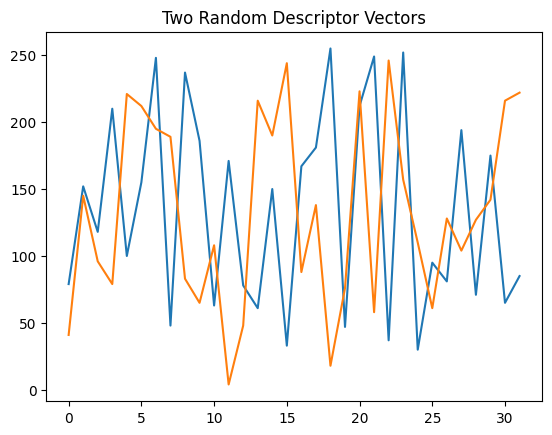

In [5]:
d1 = descriptors1[0]  # Form
d2 = descriptors2[0]  # Scan
plt.plot(d1)
plt.plot(d2)
plt.title("Two Random Descriptor Vectors")

### 3.3 Match Keypoints in the Two Images

---

`DescriptorMatcher()` Creates a descriptor matcher of a given type with the default parameters (using default constructor)

retval = cv2.DescriptorMatcher_create(descriptorMatcherType)

The function has __1 required argument__:

1. `descriptorMatcherType`: Descriptor marcher type.

---

matches = cv2.DescriptorMatcher.match(queryDescriptors, trainDescriptors[, mask])

the function has __2 required arguments__:

1. `queryDescriptors`: Query set of descriptors.
2. `trainDescriptors`: Train set of descriptors. This set is not added to the train descriptors collection stored in the class object.

In [8]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

matches = matcher.match(descriptors1, descriptors2, None)

# Sort matches by score.
matches = sorted(matches, key = lambda x: x.distance, reverse = False)

# Retain only the top 10% of matches.
numGoodMatches = int(len(matches) * 0.10)
matches = matches[:numGoodMatches]

In [9]:
idx = 0 # First index for best match.

qdx = matches[idx].queryIdx
tdx = matches[idx].trainIdx

print ("")
print ("keypoint angle: ", keypoints1[qdx].angle)
print ("keypoint size:  ", keypoints1[qdx].size)
print ("keypoint x:     ", keypoints1[qdx].pt[0])
print ("keypoint y:     ", keypoints1[qdx].pt[1])
print ("")
print ("descriptor1: ", descriptors1[qdx])
print ("")

print ("")
print ("keypoint angle: ", keypoints2[tdx].angle)
print ("keypoint size:  ", keypoints2[tdx].size)
print ("keypoint x:     ", keypoints2[tdx].pt[0])
print ("keypoint y:     ", keypoints2[tdx].pt[1])
print ("")
print ("descriptor2: ", descriptors2[tdx])
print ("")


keypoint angle:  283.39520263671875
keypoint size:   64.28160858154297
keypoint x:      89.16481018066406
keypoint y:      238.4640350341797

descriptor1:  [ 25 207  66 172 148 147 207 245  68   4  92 230  97  99 179 196  88 106
   6 238 201 186  36 189 168 229 166 128  63 154 248 168]


keypoint angle:  278.00213623046875
keypoint size:   44.6400032043457
keypoint x:      139.6800079345703
keypoint y:      460.8000183105469

descriptor2:  [ 57 207  66 174 148 147 207 245  68   4  92 230 113 225 179 196 124 106
   6 238 201 186  36 189 224 205 166 128  63 186 248 168]



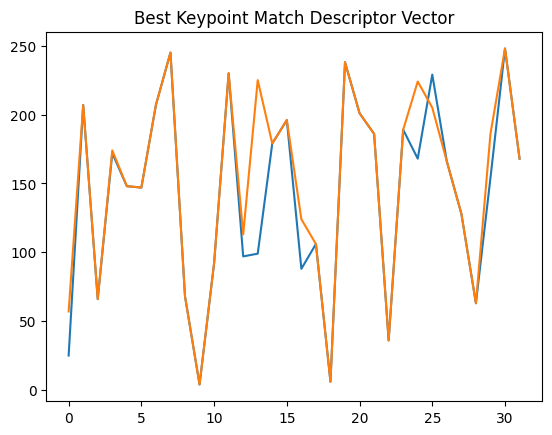

In [10]:
idx = 0 # First index for best match.
d1 = descriptors1[matches[idx].queryIdx]
d2 = descriptors2[matches[idx].trainIdx]
plt.plot(d1)
plt.plot(d2)
plt.title("Best Keypoint Match Descriptor Vector");

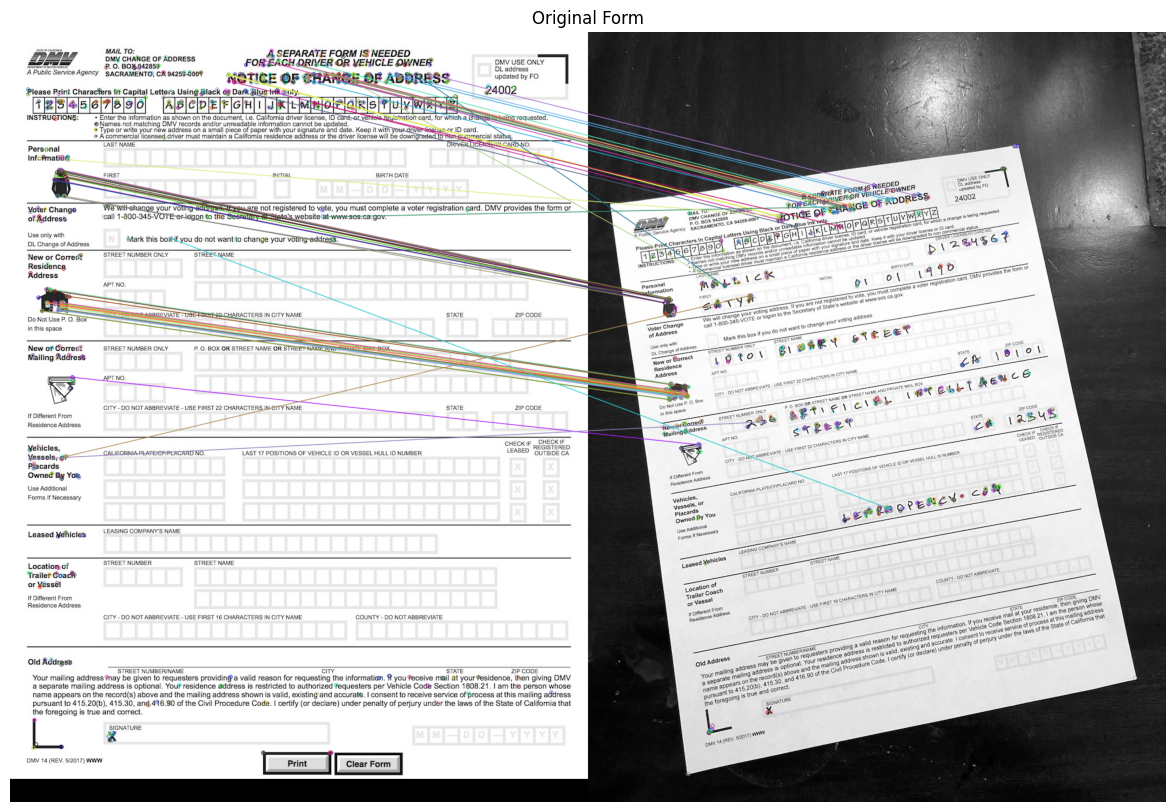

In [11]:
# Draw top matches.
img_matches = cv2.drawMatches(img_form_gray, keypoints1, img_scan_gray, keypoints2, matches, None)

plt.figure(figsize = [40,10])
plt.imshow(img_matches); plt.axis('off'); plt.title("Original Form");